In [1]:
# !pip install stable-baselines3[extra]

In [2]:
import gymnasium as gym

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tqdm import tqdm

In [4]:
from typing import Type, List

from AgentBasedModel.exchange import ExchangeAgent, Asset
from AgentBasedModel.traders import (
    Trader,
    Universalist,
    Chartist1D,
    Chartist2D,
    Fundamentalist,
    SingleTrader,
)
from AgentBasedModel.extra import Event
from AgentBasedModel.utils.math import mean, std, rolling

import random

In [5]:
from AgentBasedModel import *
from AgentBasedModel.extra import *
from AgentBasedModel.visualization import *
from AgentBasedModel.visualization.other import plot_book
from AgentBasedModel.visualization.other import plot_full_book
from AgentBasedModel.visualization.trader import *
from random import randint

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [7]:
run utils_nikita//functions.ipynb

# RL trading agent

In [8]:
class RLTrader(SingleTrader):
    def __init__(
            self,
            market: ExchangeAgent,
            timing=1,
            cash:   float | int = 1**3, #10**3,
            assets: int = 0,
            limit_inventory=100
        ):
        """
        :param market: link to exchange agent
        :param cash: trader's cash available, defaults 10**3
        :param assets: trader's number of shares hold, defaults 0
        :param access: number of future dividends known, defaults 0 (knows only current dividend)
        """
        super().__init__(market, cash, assets)
        self.type = 'RLTrader'
        
        self.timing = timing
        self.limit_inventory = limit_inventory
        self.last_move = 0
        
        self.last_cash = self.cash
        self.last_assets = self.assets
        
        self.last_qty_bid = 0
        self.last_qty_ask = 0
        
        self.last_price_ask = 0
        self.last_price_bid = 0
    
    def call(self, action): # bid, ask qty. bid, ask price

        self.last_cash = self.cash
        self.last_assets = self.assets
        
        bid_price = self.market.order_book['bid'].to_list()[0]['price']
        ask_price = self.market.order_book['ask'].to_list()[0]['price']
        
        bid_qty_action = action[0] * 10
        ask_qty_action = action[1] * 10
        
        bid_price_action = action[2]
        ask_price_action = action[3]
        
        ask_price = ask_price + (bid_price_action - 5) * 0.1
        bid_price = bid_price - (ask_price_action - 5) * 0.1
        
        if self.last_move % self.timing == 0:
            
            if self.orders:
                for i in range(len(self.orders)):
                    order = self.orders[0]
                    self._cancel_order(order)
                    
            
            # Restriction on the inventory
            if ask_qty_action - self.assets > self.limit_inventory:
                ask_qty_action = self.limit_inventory + self.assets
            
            if bid_qty_action + self.assets > self.limit_inventory:
                bid_qty_action = self.limit_inventory - self.assets
            
            
            if self.assets >= -1 * self.limit_inventory and ask_qty_action > 0:
                self._sell_limit(ask_qty_action, ask_price)
            
            if self.assets <= self.limit_inventory and bid_qty_action > 0:
                self._buy_limit(bid_qty_action, bid_price)
            
            self.last_qty_ask = ask_qty_action
            self.last_qty_bid = bid_qty_action
            
            self.last_price_ask = ask_price
            self.last_price_bid = bid_price
            
#             print('ask', ask_qty_action, ask_price)
#             print('bid', bid_qty_action, bid_price)
            
        self.last_move += 1

# Simulator-gym

In [9]:
rewards_container = []

agent_states_container = []

In [10]:
class Simulator_gym(gym.Env):
    """
    Simulator is responsible for launching agents' actions and executing scenarios
    """
    # todo: Only traders are to be passed, trader -> trader.exchange -> trader.exchange.asset. Use dict comprehension to get unique items.
    def __init__(
            self,
            assets:    List[Type[Asset]],
            exchanges: List[ExchangeAgent],
            traders:   List[Type[Trader]],
            events:    List[Type[Event]] = None,
            
            observation_space = None,
            action_space = None,
        
            random_seed = None,
            
            SGU = None,
            device = 'cuda'
        ):
        
        super(Simulator_gym, self).__init__()
        
        self.assets = assets
        self.exchanges = exchanges
        self.traders = traders
        self.events = [event.link(self) for event in events] if events else None  # link all events to simulator

        self.info = SimulatorInfo(exchanges, traders)
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.called_traders = set()
        self.initial_call = 0
        
        self.random_seed = random_seed
        
        self.RL_agent = None
        
        self.FC = FeatureCollector(self.info, self.exchanges[0])
        
        self.SGU = SGU
        
    def get_reward(self):
        if not self.RL_agent:
            return 0
        
        current_ask_qty = 0
        current_bid_qty = 0
        
        current_ask_price = 0
        current_bid_price = 0
        
        for i in range(len(self.RL_agent.orders)):
            
            order = self.RL_agent.orders[i]
            
            if order.order_type == 'ask':
                current_ask_qty = order.qty
                
            elif order.order_type == 'bid':
                current_bid_qty = order.qty
                
        current_ask_price = self.RL_agent.last_price_ask
        current_bid_price = self.RL_agent.last_price_bid
        
        executed_asks = self.RL_agent.last_qty_ask - current_ask_qty
        executed_bids = self.RL_agent.last_qty_bid - current_bid_qty
        
        reward = min(executed_asks, executed_bids) * (current_ask_price - current_bid_price) / 5
        reward = reward - abs(self.RL_agent.last_assets - (executed_asks - executed_bids)) / (self.RL_agent.limit_inventory)
        
        
        rewards_container.append([reward, executed_asks, executed_bids, current_ask_price, current_bid_price])
        
        agent_states_container.append([self.RL_agent.assets, self.RL_agent.cash, self.RL_agent.equity()])
        
        return reward
        
        
#         delta_cash = self.RL_agent.cash - self.RL_agent.last_cash
#         delta_assets = self.RL_agent.assets - self.RL_agent.last_assets

#         return delta_cash - abs(self.RL_agent.last_assets + delta_assets)/self.RL_agent.limit_inventory
            
#             return delta_cash - 0.1 * (self.RL_agent.assets + delta_assets)
#             return (self.RL_agent.cash + self.RL_agent.assets * self.exchanges[0].price()) - 10**3 - abs(self.RL_agent.assets)
        

    def simulate(self, n_iter: int, silent: bool = False) -> object:
        
        for it in tqdm(range(n_iter), desc='Simulation', disable=silent):
            
            # Call scenario
            if self.events:
                for event in self.events:
                    event.call(it)

            # Capture current info
            self.info.capture()

            # Call Traders
            random.shuffle(self.traders)
            

            for trader in self.traders:
                if type(trader) == Universalist:
                    trader.change_strategy(self.info)
                if type(trader) in (Universalist, Chartist1D, Chartist2D):
                    trader.change_sentiment(self.info)
                if type(trader) == RLTrader:
                    continue

                trader.call()    # trader's action
            
            # Pay Traders
            for trader in self.traders:
                trader.income()  # trader's dividend and interest

            # Update assets
            for asset in self.assets:
                asset.update()  # generate next dividend
        
            for exchange in self.exchanges:
                exchange.transactions.iteration += 1
        
        return self
    
    def reset(self, seed=None, options=None):
        
        self.random_seed += 1001
        
        market_agents=[40, 40, 40, 1]
        dividend = 10
        risk_free_rate = 0.05
        price = 200
        
        random.seed(self.random_seed)

        assets = [Stock(dividend)]

        simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

        simple_traders = [
            *[Random(simple_exchange) for _ in range(market_agents[0])],
            *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
            *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
            *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
            *[RLTrader(simple_exchange)]
        ]
        
        self.assets = assets
        self.exchanges = [simple_exchange]
        self.traders = simple_traders
        self.events = None
        
        self.info = SimulatorInfo(self.exchanges, self.traders)
        
        self.called_traders = set()
        self.initial_call = 0
        
        self.RL_agent = None
        
        self.simulate(1, silent=False)
        print('reset')
        
        self.FC = FeatureCollector(self.info, self.exchanges[0])
        
        features = self.FC.get_features()
        
        if self.SGU:
            features = torch.Tensor(features).to(device)
            signals = self.SGU(features)
            observations = np.array(signals.to('cpu'), dtype='float32')

        else:
            features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
            observations = np.array(features.values[0], dtype='float32')
                        
        observations = np.append(observations, np.float32(0))
        
        reward = self.get_reward()
        terminated = False
        truncated = False
        info = dict()

        return observations, info
        
        
    def step(self, action):
        
        if self.initial_call == 0:
            self.simulate(1, silent=False)
        
        if self.initial_call == 1:
            trader = self.RL_agent
            trader.call(action)
            self.called_traders.add(trader)
        
        self.initial_call = 1
        
        for trader in self.traders:
            if trader in self.called_traders:
                pass
            
            else:
                if type(trader) == Universalist:
                    trader.change_strategy(self.info)
                if type(trader) in (Universalist, Chartist1D, Chartist2D):
                    try:
                        trader.change_sentiment(self.info)
                    except:
                        pass
                if type(trader) == RLTrader:
                    
                    self.RL_agent = trader
                    
                    features = self.FC.get_features()
                    
                    if self.SGU:
                        features = torch.Tensor(features).to(device)
                        signals = self.SGU(features)
                        observations = np.array(signals.to('cpu'), dtype='float32')
                    
                    else:
                        features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
                        observations = np.array(features.values[0], dtype='float32')
                        
                    observations = np.append(observations, np.float32(self.RL_agent.assets))

                    reward = self.get_reward()
                    
                    terminated = False
                    truncated = False
                    info = dict()
                
                    return observations, reward, terminated, truncated, info

                trader.call()
        
        # Finish cycle
        # Pay Traders
        for trader in self.traders:
            if type(trader) == RLTrader:
                continue
            else:
                trader.income()  # trader's dividend and interest

        # Update assets
        for asset in self.assets:
            asset.update()  # generate next dividend

        for exchange in self.exchanges:
            exchange.transactions.iteration += 1
        
        # Start new cycle
        
        # Call scenario
        if self.events:
            for event in self.events:
                event.call(it)

        # Capture current info
        self.info.capture()

        # Call Traders
        random.shuffle(self.traders)
        
        self.called_traders = set()
        
        for trader in self.traders:
            if type(trader) == Universalist:
                trader.change_strategy(self.info)
            if type(trader) in (Universalist, Chartist1D, Chartist2D):
                try:
                    trader.change_sentiment(self.info)
                except:
                    pass
            if type(trader) == RLTrader:
                
                self.RL_agent = trader
                
                features = self.FC.get_features()
                    
                if self.SGU:
                    features = torch.Tensor(features).to(device)
                    signals = self.SGU(features)
                    observations = np.array(signals.to('cpu'), dtype='float32')

                else:
                    features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
                    observations = np.array(features.values[0], dtype='float32')

                observations = np.append(observations, np.float32(self.RL_agent.assets))
                    
                reward = self.get_reward()
                terminated = False
                truncated = False
                info = dict()
                
                return observations, reward, terminated, truncated, info

            trader.call()    # trader's action
            self.called_traders.add(trader)

        

# Environment setup

In [11]:
# simulator settings
market_agents=[40, 40, 40, 1]
random_state = 21140
dividend = 10
risk_free_rate = 0.05
price = 200

# gym settings

# observation space
obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=21)

# action space
# action_space = gym.spaces.MultiDiscrete(np.array([151, 151, 101, 101]), seed=22) # bid, ask qty. bid, ask price
action_space = gym.spaces.MultiDiscrete(np.array([10, 10, 16, 16]), seed=22) # bid, ask qty. bid, ask price

# gym definition
random.seed(random_state)

assets = [Stock(dividend)]

simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
#     *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
]

# simple_sim = Simulator(**{
#     'assets': [assets[0]],
#     'exchanges': [simple_exchange],
#     'traders': simple_traders[:-1]
# })

my_gym = Simulator_gym(**{
    'assets': [assets[0]],
    'exchanges': [simple_exchange],
    'traders': simple_traders}, 
                       
    observation_space = obs_space,
    action_space = action_space,
    random_seed = random_state,)

In [12]:
random.seed(random_state)

assets = [Stock(dividend)]

simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
    *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
]

simple_sim = Simulator(**{
    'assets': [assets[0]],
    'exchanges': [simple_exchange],
    'traders': simple_traders[:-1]
})

In [13]:
simple_sim = Simulator(**{
    'assets': [assets[0]],
    'exchanges': [simple_exchange],
    'traders': simple_traders[:-1]
})

In [14]:
ag_1 = RLTrader(simple_exchange)

In [15]:
ag_1.equity()

1.0

In [16]:
# from stable_baselines3.common.env_checker import check_env

In [17]:
# check_env(my_gym, warn=True)

# Check simulation

In [18]:
# actions_ = actions_[:-1]

In [19]:
# len(actions_)

In [20]:
# iterat = 0
# my_gym.reset()

# for el in actions_:
#     my_gym.step(el)
#     iterat += 1
    
#     if iterat > 53:
#         plot_full_book(my_gym.info, idx=my_gym.exchanges[0].id)

In [21]:
# for trader in my_gym.traders:
#     print(trader, trader.assets)

In [22]:
# my_gym.info.fundamental

# Training

In [23]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_vec_env

In [24]:
# Instantiate the env
# vec_env = make_vec_env(Simulator_gym, n_envs=1, env_kwargs=dict())

In [25]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan, SubprocVecEnv

In [26]:
def make_env(seed=2509, no_mm = True):
    
    
    if no_mm:
        market_agents=[40, 40, 40, 0]
    else:
        market_agents=[40, 40, 40, 1]
    
    random_state = seed
    dividend = 10
    risk_free_rate = 0.05
    price = 200

    # gym settings

    # observation space
    obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=random_state)

    # action space
    action_space = gym.spaces.MultiDiscrete(np.array([10, 10, 16, 16]), seed=random_state) # bid, ask qty. bid, ask price
    
    random.seed(random_state)

    assets = [Stock(dividend)]

    simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)
    
    simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
    *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
    ]
    
    
#     settings = {
#         'assets': [assets[0]],
#         'exchanges': [simple_exchange],
#         'traders': simple_traders, 

#         'observation_space': obs_space,
#         'action_space': action_space,
#         'random_seed': random_state,
#     }

    my_gym = Simulator_gym(**{
        'assets': [assets[0]],
        'exchanges': [simple_exchange],
        'traders': simple_traders}, 

        observation_space = obs_space,
        action_space = action_space,
        random_seed = random_state,
        )
    
    return my_gym
#     return settings

In [27]:
# my_gym = Simulator_gym(**{
#     'assets': [assets[0]],
#     'exchanges': [simple_exchange],
#     'traders': simple_traders}, 
                       
#     observation_space = obs_space,
#     action_space = action_space,
#     random_seed = random_state,)

# env = SubprocVecEnv([lambda: Simulator_gym(**{
#     'assets': [assets[0]],
#     'exchanges': [simple_exchange],
#     'traders': simple_traders}, 
                       
#     observation_space = obs_space,
#     action_space = action_space,
#     random_seed = random_state,)])

# env = VecCheckNan(env, raise_exception=True)

# training algorithm

In [75]:
from stable_baselines3.common.logger import configure

tmp_path = "/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_regular_increased_2/no_mm/model_50000_may_25/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

Logging to /Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_regular_increased_2/no_mm/model_50000_may_25/


In [76]:
my_env = DummyVecEnv([make_env])

In [77]:
policy_kwargs = dict(
    net_arch=dict(pi=[64, 64, 64, 64], vf=[64, 64]),
)

In [78]:
model = PPO("MlpPolicy", my_env, n_steps=25, verbose=1, batch_size=25, policy_kwargs=policy_kwargs)
model.set_logger(new_logger)

Using cuda device


In [79]:
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=17, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=17, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=52, bias=True)
  (value_net): Linear(in_features=64, 

In [80]:
from tqdm import trange

In [81]:
capturing_index=[5000, 10000, 20000, 30000, 40000]

for i in range(20000 // 250):
    
    model.learn(250)
    
    if i * 250 in capturing_index:
        print(i * 250)
        model.save(tmp_path + f"model_{i * 250}")

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.52it/s]


---------------------------
| time/              |    |
|    fps             | 26 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 25 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/                  |             |
|    approx_kl            | 0.022741087 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.1       |
|    explained_variance   | 0.0519      |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0795     |
|    value_loss           | 25          |
-----------------------------------------
-----------------------------------------
| time

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.07it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.62it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.021050503 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10         |
|    explained_variance   | 0.442       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.3        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0556     |
|    value_loss           | 29.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.033944983 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.63       |
|    explained_variance   | -0.856      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.89        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0737     |
|    value_loss           | 16.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.41it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.66it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0036132955 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.48        |
|    explained_variance   | -7.55        |
|    learning_rate        | 0.0003       |
|    loss                 | 5            |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.0271      |
|    value_loss           | 11.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.18it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0007424879 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.27        |
|    explained_variance   | -0.00848     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.34         |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.00341     |
|    value_loss           | 24.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 332.93it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.48it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009439611 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.48       |
|    explained_variance   | -0.000268   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.5         |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0409     |
|    value_loss           | 5.67        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.42it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.28it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0005100918 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.27        |
|    explained_variance   | -0.311       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.53         |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00111     |
|    value_loss           | 20.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0038373517 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.56        |
|    explained_variance   | 0.139        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.3         |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.0107      |
|    value_loss           | 45.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 256.27it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.81it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0066138576 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.52        |
|    explained_variance   | -1.37        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.121        |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.0235      |
|    value_loss           | 0.547        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.95it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.000629735 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.06       |
|    explained_variance   | 0.411       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.26        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.00954    |
|    value_loss           | 13.2        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 23        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 330.91it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.14it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.02381137 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.63      |
|    explained_variance   | -0.0771    |
|    learning_rate        | 0.0003     |
|    loss                 | 8.4        |
|    n_updates            | 1000       |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 18.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.80it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.50it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.001295774 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.16       |
|    explained_variance   | -0.172      |
|    learning_rate        | 0.0003      |
|    loss                 | 5.77        |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.00444    |
|    value_loss           | 15.5        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


---------------------------------------
| time/                   |           |
|    fps                  | 30        |
|    iterations           | 1         |
|    time_elapsed         | 0         |
|    total_timesteps      | 25        |
| train/                  |           |
|    approx_kl            | 0.1705883 |
|    clip_fraction        | 0.452     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.45     |
|    explained_variance   | 0.34      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.127    |
|    n_updates            | 1200      |
|    policy_gradient_loss | -0.103    |
|    value_loss           | 0.0353    |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         |
| train/                  |       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 253.78it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.17it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018341128 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.03       |
|    explained_variance   | 0.127       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.98        |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0398     |
|    value_loss           | 10.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.08it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.04496141 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.4       |
|    explained_variance   | -0.0469    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0992     |
|    n_updates            | 1400       |
|    policy_gradient_loss | -0.0655    |
|    value_loss           | 0.457      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.45it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.06088506 |
|    clip_fraction        | 0.288      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.26      |
|    explained_variance   | -0.138     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0873     |
|    n_updates            | 1500       |
|    policy_gradient_loss | -0.074     |
|    value_loss           | 0.561      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.89it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.41it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.045664728 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.58       |
|    explained_variance   | -0.197      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.548       |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.06       |
|    value_loss           | 1.37        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.39it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.92it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.012494208 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | -0.223      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.461       |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.0304     |
|    value_loss           | 1.11        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 165.63it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.048172135 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.02       |
|    explained_variance   | -1.87       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00409     |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.0449     |
|    value_loss           | 0.257       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.44it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.047710206 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.25       |
|    explained_variance   | -0.742      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0291     |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.049      |
|    value_loss           | 0.123       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.36it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.80it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013152193 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | -0.0461     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.39        |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 3.24        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.25it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.10244788 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.56      |
|    explained_variance   | -0.688     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.127      |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0474    |
|    value_loss           | 0.54       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.86it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.21it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010680084 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.64       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.176       |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.575       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.75it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.81it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.04883933 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.97      |
|    explained_variance   | -3.98      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0677    |
|    n_updates            | 2300       |
|    policy_gradient_loss | -0.0518    |
|    value_loss           | 0.057      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.05it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03045149 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.49      |
|    explained_variance   | -6.46      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0201    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0404    |
|    value_loss           | 0.145      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.78it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.036596674 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | -0.104      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0463     |
|    n_updates            | 2500        |
|    policy_gradient_loss | -0.0331     |
|    value_loss           | 0.0293      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.55it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.12it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.011916356 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.92       |
|    explained_variance   | 0.0698      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.421       |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 1.22        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018970909 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | -0.243      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0194      |
|    n_updates            | 2700        |
|    policy_gradient_loss | -0.0439     |
|    value_loss           | 0.222       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.27it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.09001273 |
|    clip_fraction        | 0.064      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.1       |
|    explained_variance   | 0.458      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.356      |
|    n_updates            | 2800       |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.977      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.25it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.46it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.02262023 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.55      |
|    explained_variance   | 0.0424     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.09       |
|    n_updates            | 2900       |
|    policy_gradient_loss | -0.0308    |
|    value_loss           | 2.59       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.11it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.031237446 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.498       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0395     |
|    n_updates            | 3000        |
|    policy_gradient_loss | -0.0384     |
|    value_loss           | 0.0682      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.12it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.92it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.014194245 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | -0.398      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.372       |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.0296     |
|    value_loss           | 1.01        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.019476134 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.18       |
|    explained_variance   | -0.468      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0438      |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.0378     |
|    value_loss           | 0.304       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.20it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.030793948 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.461       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0257     |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.048      |
|    value_loss           | 0.11        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 336.41it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010256789 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | -2.99       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0164     |
|    n_updates            | 3400        |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.0349      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.83it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.36it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0013417315 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.981       |
|    explained_variance   | -0.549       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51         |
|    n_updates            | 3500         |
|    policy_gradient_loss | -0.00136     |
|    value_loss           | 3.26         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.38it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03198261 |
|    clip_fraction        | 0.068      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.92      |
|    explained_variance   | -0.726     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.000384  |
|    n_updates            | 3600       |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 0.0923     |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.85it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.02266995 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.97      |
|    explained_variance   | -2.24      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0206    |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 0.0629     |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0014536452 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.272        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.343        |
|    n_updates            | 3800         |
|    policy_gradient_loss | -0.00686     |
|    value_loss           | 0.788        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.52it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.01it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.034489416 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | -0.0335     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0338      |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.0478     |
|    value_loss           | 0.247       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.16it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.09it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.012453303 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -0.228      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.154       |
|    n_updates            | 4000        |
|    policy_gradient_loss | -0.0235     |
|    value_loss           | 0.429       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.07it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008811361 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.56        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00645     |
|    n_updates            | 4100        |
|    policy_gradient_loss | -0.00983    |
|    value_loss           | 0.0501      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.88it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.49it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03175389 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | -0.14      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0103    |
|    n_updates            | 4200       |
|    policy_gradient_loss | -0.0256    |
|    value_loss           | 0.0815     |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004286296 |
|    clip_fraction        | 0.008       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.339       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0109     |
|    n_updates            | 4300        |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 0.0704      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.92it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.37it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.20149784 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.93      |
|    explained_variance   | -1.08      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0147     |
|    n_updates            | 4400       |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 0.121      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 22            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00011795997 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.672        |
|    explained_variance   | -0.422        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.517         |
|    n_updates            | 4500          |
|    policy_gradient_loss | -0.000397     |
|    value_loss           | 1.37          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 106.52it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 22            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 6.8578716e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.02         |
|    explained_variance   | -0.392        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.337         |
|    n_updates            | 4600          |
|    policy_gradient_loss | 0.000375      |
|    value_loss           | 0.746         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.33it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.035505384 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.331       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.123       |
|    n_updates            | 4700        |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.371       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.48it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.56it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0017633605 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.94        |
|    explained_variance   | 0.118        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0469       |
|    n_updates            | 4800         |
|    policy_gradient_loss | 0.00142      |
|    value_loss           | 0.129        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.08it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 222.51it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 20            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00071499345 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.75         |
|    explained_variance   | -0.473        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0447        |
|    n_updates            | 4900          |
|    policy_gradient_loss | -0.00256      |
|    value_loss           | 0.195         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0033576488 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.656       |
|    explained_variance   | 0.0755       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.415        |
|    n_updates            | 5000         |
|    policy_gradient_loss | -0.0107      |
|    value_loss           | 1.13         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.83it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 332.20it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0043662856 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | -0.995       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.042        |
|    n_updates            | 5100         |
|    policy_gradient_loss | -0.00752     |
|    value_loss           | 0.139        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.31it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 328.99it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009940013 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.886      |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00922    |
|    n_updates            | 5200        |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.0817      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.04it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0049088383 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | -0.482       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.162        |
|    n_updates            | 5300         |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 0.458        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.67it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.15it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.016699854 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.869      |
|    explained_variance   | 0.0123      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.798       |
|    n_updates            | 5400        |
|    policy_gradient_loss | -0.00723    |
|    value_loss           | 1.71        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.17it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.25it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009839873 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.177       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00411     |
|    n_updates            | 5500        |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.117       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.72it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0015350103 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.684       |
|    explained_variance   | 0.432        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0373       |
|    n_updates            | 5600         |
|    policy_gradient_loss | -0.00745     |
|    value_loss           | 0.15         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.89it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.22it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.24434234 |
|    clip_fraction        | 0.032      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.26      |
|    explained_variance   | -0.203     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00643    |
|    n_updates            | 5700       |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 0.143      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.67it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.87it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010671646 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | -2.75       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0984      |
|    n_updates            | 5800        |
|    policy_gradient_loss | 0.000359    |
|    value_loss           | 0.288       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.38it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.96it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.04282345 |
|    clip_fraction        | 0.032      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.54      |
|    explained_variance   | -0.661     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.21       |
|    n_updates            | 5900       |
|    policy_gradient_loss | -0.00494   |
|    value_loss           | 2.63       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.61it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.41it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0073601794 |
|    clip_fraction        | 0.04         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.727       |
|    explained_variance   | 0.112        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.115        |
|    n_updates            | 6000         |
|    policy_gradient_loss | -0.0125      |
|    value_loss           | 0.29         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.35it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009586709 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.84       |
|    explained_variance   | -1.48       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0403      |
|    n_updates            | 6100        |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.228       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.24it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.04it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0007979464 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.95        |
|    explained_variance   | 0.324        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29         |
|    n_updates            | 6200         |
|    policy_gradient_loss | 0.00726      |
|    value_loss           | 3.14         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 336.46it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.42it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0014292669 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.604       |
|    explained_variance   | -0.936       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00788      |
|    n_updates            | 6300         |
|    policy_gradient_loss | -0.0069      |
|    value_loss           | 0.109        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.74it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0053458977 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | -0.694       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000493    |
|    n_updates            | 6400         |
|    policy_gradient_loss | -0.013       |
|    value_loss           | 0.132        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018024303 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.646      |
|    explained_variance   | -1.3        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.912       |
|    n_updates            | 6500        |
|    policy_gradient_loss | -0.0223     |
|    value_loss           | 2.24        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.04it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.56it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.2354851e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.342        |
|    explained_variance   | -0.549        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0799        |
|    n_updates            | 6600          |
|    policy_gradient_loss | -0.000701     |
|    value_loss           | 0.191         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.56it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.1457671e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.284        |
|    explained_variance   | -2.84         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.119         |
|    n_updates            | 6700          |
|    policy_gradient_loss | 6.26e-05      |
|    value_loss           | 0.299         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.46it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0012196135 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.268       |
|    explained_variance   | 0.00389      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.238        |
|    n_updates            | 6800         |
|    policy_gradient_loss | -0.00265     |
|    value_loss           | 0.538        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.78it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00014814854 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.484        |
|    explained_variance   | 0.353         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.297         |
|    n_updates            | 6900          |
|    policy_gradient_loss | 0.000485      |
|    value_loss           | 0.771         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.48it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.98it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0060252664 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.402       |
|    explained_variance   | 0.449        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0184       |
|    n_updates            | 7000         |
|    policy_gradient_loss | -0.00682     |
|    value_loss           | 0.103        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.58it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.77it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.8715858e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.33         |
|    explained_variance   | 0.151         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.172         |
|    n_updates            | 7100          |
|    policy_gradient_loss | -4.74e-05     |
|    value_loss           | 0.398         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00033498288 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.187        |
|    explained_variance   | -0.392        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.109         |
|    n_updates            | 7200          |
|    policy_gradient_loss | -0.00245      |
|    value_loss           | 0.378         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 123.45it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.3661385e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.192        |
|    explained_variance   | 0.133         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.969         |
|    n_updates            | 7300          |
|    policy_gradient_loss | -8.25e-05     |
|    value_loss           | 2.03          |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.46it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.32it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010836239 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.566      |
|    explained_variance   | -0.386      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0248      |
|    n_updates            | 7400        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.114       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.72it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.14it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 1.66893e-08 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.162      |
|    explained_variance   | -0.00297    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.533       |
|    n_updates            | 7500        |
|    policy_gradient_loss | -1.51e-06   |
|    value_loss           | 1.08        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.45it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.0299682e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.201        |
|    explained_variance   | -0.178        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.182         |
|    n_updates            | 7600          |
|    policy_gradient_loss | -0.000204     |
|    value_loss           | 0.38          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.26it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.00940731 |
|    clip_fraction        | 0.052      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.153      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.65       |
|    n_updates            | 7700       |
|    policy_gradient_loss | -0.00812   |
|    value_loss           | 3.57       |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 181.94it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.70it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.6960372e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.123        |
|    explained_variance   | -0.144        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.047         |
|    n_updates            | 7800          |
|    policy_gradient_loss | -0.00137      |
|    value_loss           | 0.179         |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.36it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.56it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.3593178e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.219        |
|    explained_variance   | -0.425        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.117         |
|    n_updates            | 7900          |
|    policy_gradient_loss | -7.47e-05     |
|    value_loss           | 0.35          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           

In [82]:
capturing_index=[5000, 10000, 20000, 30000, 40000]

for i in range(30000 // 250):
    
    model.learn(250)
    
    if i * 250 + 20000 in capturing_index:
        print(i * 250 + 20000)
        model.save(tmp_path + f"model_{i * 250 + 20000}")

Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.03it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.31it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.006149499 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | -1.06       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.05        |
|    n_updates            | 8000        |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 0.169       |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.41it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.44it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018202806 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.384      |
|    explained_variance   | -1.15       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0529      |
|    n_updates            | 8100        |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.189       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.87it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0003943944 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | -1.73        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.238        |
|    n_updates            | 8200         |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 0.634        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.30it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.70it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0007310915 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.749       |
|    explained_variance   | -9.62        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.59         |
|    n_updates            | 8300         |
|    policy_gradient_loss | 0.00109      |
|    value_loss           | 3.5          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.56it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.26293924 |
|    clip_fraction        | 0.06       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.755     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00691   |
|    n_updates            | 8400       |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 0.102      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.61it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01647337 |
|    clip_fraction        | 0.04       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.579     |
|    explained_variance   | -4.89      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0173     |
|    n_updates            | 8500       |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 0.128      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.33it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0039951755 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.376       |
|    explained_variance   | 0.351        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0777       |
|    n_updates            | 8600         |
|    policy_gradient_loss | -0.00704     |
|    value_loss           | 0.2          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.60it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 6.840229e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.314       |
|    explained_variance   | -0.109       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.02         |
|    n_updates            | 8700         |
|    policy_gradient_loss | 0.00147      |
|    value_loss           | 4.45         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.95it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.41it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.007210805 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.463      |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0311      |
|    n_updates            | 8800        |
|    policy_gradient_loss | -0.00565    |
|    value_loss           | 0.115       |
-----------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 28             |
|    iterations           | 2              |
|    time_elapsed         | 1              |
|    total_timestep

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.28it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0017506528 |
|    clip_fraction        | 0.008        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.141        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0922       |
|    n_updates            | 8900         |
|    policy_gradient_loss | -0.0074      |
|    value_loss           | 0.325        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.38it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 3.027916e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.308       |
|    explained_variance   | -1.56        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0663       |
|    n_updates            | 9000         |
|    policy_gradient_loss | 1.81e-05     |
|    value_loss           | 0.203        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.33it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.81it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 7.820129e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.307       |
|    explained_variance   | -0.383       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0607       |
|    n_updates            | 9100         |
|    policy_gradient_loss | -0.000724    |
|    value_loss           | 0.205        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009738688 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | -7.06       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.143       |
|    n_updates            | 9200        |
|    policy_gradient_loss | -0.00875    |
|    value_loss           | 0.433       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 9.059906e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.229       |
|    explained_variance   | -2.36        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.198        |
|    n_updates            | 9300         |
|    policy_gradient_loss | 0.000285     |
|    value_loss           | 0.456        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.28it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.0183792e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.179        |
|    explained_variance   | 0.315         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.229         |
|    n_updates            | 9400          |
|    policy_gradient_loss | -0.000295     |
|    value_loss           | 0.547         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.64it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.58610654 |
|    clip_fraction        | 0.076      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.414     |
|    explained_variance   | 0.205      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0103    |
|    n_updates            | 9500       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.0899     |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.21it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 282.06it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.5749205e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.155        |
|    explained_variance   | -0.00863      |
|    learning_rate        | 0.0003        |
|    loss                 | 0.102         |
|    n_updates            | 9600          |
|    policy_gradient_loss | 0.000177      |
|    value_loss           | 0.254         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.80it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.8233528e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.205        |
|    explained_variance   | 0.256         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.00887       |
|    n_updates            | 9700          |
|    policy_gradient_loss | -0.000395     |
|    value_loss           | 0.0275        |
-------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 22        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    tot

Simulation: 100%|██████████| 1/1 [00:00<00:00, 281.78it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.85it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 2.109766e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | -4.04        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.169        |
|    n_updates            | 9800         |
|    policy_gradient_loss | -0.000221    |
|    value_loss           | 0.388        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 2.787113e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.3         |
|    explained_variance   | 0.321        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0626       |
|    n_updates            | 9900         |
|    policy_gradient_loss | -8.79e-05    |
|    value_loss           | 0.135        |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.52it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.94it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013648512 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.471      |
|    explained_variance   | -1.24       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0087      |
|    n_updates            | 10000       |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 0.121       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.95it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0065070176 |
|    clip_fraction        | 0.04         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.553       |
|    explained_variance   | -0.633       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.309        |
|    n_updates            | 10100        |
|    policy_gradient_loss | -0.0106      |
|    value_loss           | 0.738        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.96it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0025887226 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.635       |
|    explained_variance   | 0.005        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.82         |
|    n_updates            | 10200        |
|    policy_gradient_loss | 0.00386      |
|    value_loss           | 8.27         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.39it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.20915578 |
|    clip_fraction        | 0.06       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.804     |
|    explained_variance   | -0.546     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.252      |
|    n_updates            | 10300      |
|    policy_gradient_loss | -0.00741   |
|    value_loss           | 0.576      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.13it/s]


---------------------------------------
| time/                   |           |
|    fps                  | 26        |
|    iterations           | 1         |
|    time_elapsed         | 0         |
|    total_timesteps      | 25        |
| train/                  |           |
|    approx_kl            | 1.0633607 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.851    |
|    explained_variance   | 0.231     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.00463   |
|    n_updates            | 10400     |
|    policy_gradient_loss | -0.0264   |
|    value_loss           | 0.161     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 25        |
|    iterations           | 2         |
|    time_elapsed         | 1         |
|    total_timesteps      | 50        |
| train/                  |           |


Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.75it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005219674 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.345      |
|    explained_variance   | -5.8        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.144       |
|    n_updates            | 10500       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.439       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.96it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.07it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.016184209 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.6        |
|    explained_variance   | -0.0637     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.319       |
|    n_updates            | 10600       |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.87        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0081968475 |
|    clip_fraction        | 0.032        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.818       |
|    explained_variance   | -4.83        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.217        |
|    n_updates            | 10700        |
|    policy_gradient_loss | -0.0101      |
|    value_loss           | 0.544        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00010709047 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.391        |
|    explained_variance   | 0.172         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.122         |
|    n_updates            | 10800         |
|    policy_gradient_loss | -0.000675     |
|    value_loss           | 0.376         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.002045064 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.579      |
|    explained_variance   | -0.352      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.892       |
|    n_updates            | 10900       |
|    policy_gradient_loss | 0.00404     |
|    value_loss           | 1.88        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.99it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.6725064e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.241        |
|    explained_variance   | -2.47         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0491        |
|    n_updates            | 11000         |
|    policy_gradient_loss | -0.000462     |
|    value_loss           | 0.128         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.47it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.93it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 29            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.6087036e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.247        |
|    explained_variance   | -1.45         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.122         |
|    n_updates            | 11100         |
|    policy_gradient_loss | -0.000947     |
|    value_loss           | 0.318         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 330.91it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.41it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 2.555847e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | -0.699       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0554       |
|    n_updates            | 11200        |
|    policy_gradient_loss | 0.000475     |
|    value_loss           | 0.125        |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.31366274 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.195     |
|    explained_variance   | 0.304      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.141      |
|    n_updates            | 11300      |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 0.401      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.60it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.21it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004040334 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.302      |
|    explained_variance   | 0.0995      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00413     |
|    n_updates            | 11400       |
|    policy_gradient_loss | -0.00818    |
|    value_loss           | 0.0432      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.09it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.05it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.20585014 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.824     |
|    explained_variance   | 0.372      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0274     |
|    n_updates            | 11500      |
|    policy_gradient_loss | -0.0249    |
|    value_loss           | 0.172      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.99it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.48it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.7857551e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.175        |
|    explained_variance   | -0.673        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.274         |
|    n_updates            | 11600         |
|    policy_gradient_loss | -0.000313     |
|    value_loss           | 0.758         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.27it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.30it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 8.528233e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | -0.102       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0995       |
|    n_updates            | 11700        |
|    policy_gradient_loss | 2.59e-05     |
|    value_loss           | 0.282        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.70it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 29            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.6782284e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.259        |
|    explained_variance   | -0.00738      |
|    learning_rate        | 0.0003        |
|    loss                 | 0.609         |
|    n_updates            | 11800         |
|    policy_gradient_loss | 0.000355      |
|    value_loss           | 1.45          |
-------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 22        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    tot

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0009718871 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.415       |
|    explained_variance   | 0.479        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.334        |
|    n_updates            | 11900        |
|    policy_gradient_loss | -0.00141     |
|    value_loss           | 0.815        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.73it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.07277522 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.212      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.13       |
|    n_updates            | 12000      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 0.347      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.60it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 29            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00036180258 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.208        |
|    explained_variance   | -1.17         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.03          |
|    n_updates            | 12100         |
|    policy_gradient_loss | -0.00196      |
|    value_loss           | 0.129         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.26it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 2.439022e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.634        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0831       |
|    n_updates            | 12200        |
|    policy_gradient_loss | 1.94e-05     |
|    value_loss           | 0.178        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.95it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.2820702e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.191        |
|    explained_variance   | -4.79         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.182         |
|    n_updates            | 12300         |
|    policy_gradient_loss | -4.69e-05     |
|    value_loss           | 0.485         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 282.08it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.44it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 7.6389315e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.18         |
|    explained_variance   | 0.335         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.563         |
|    n_updates            | 12400         |
|    policy_gradient_loss | -0.000162     |
|    value_loss           | 1.17          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.46it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


--------------------------------------
| time/                   |          |
|    fps                  | 29       |
|    iterations           | 1        |
|    time_elapsed         | 0        |
|    total_timesteps      | 25       |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.125   |
|    explained_variance   | 0.453    |
|    learning_rate        | 0.0003   |
|    loss                 | 0.0603   |
|    n_updates            | 12500    |
|    policy_gradient_loss | 8.24e-07 |
|    value_loss           | 0.13     |
--------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 28       |
|    iterations           | 2        |
|    time_elapsed         | 1        |
|    total_timesteps      | 50       |
| train/                  |          |
|    approx_kl           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.32it/s]


---------------------------------------
| time/                   |           |
|    fps                  | 30        |
|    iterations           | 1         |
|    time_elapsed         | 0         |
|    total_timesteps      | 25        |
| train/                  |           |
|    approx_kl            | 0.8650246 |
|    clip_fraction        | 0.036     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.33     |
|    explained_variance   | 0.0408    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0975    |
|    n_updates            | 12600     |
|    policy_gradient_loss | -0.00539  |
|    value_loss           | 0.232     |
---------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.79it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.71it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.1457671e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.103        |
|    explained_variance   | -0.421        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0844        |
|    n_updates            | 12700         |
|    policy_gradient_loss | 8.39e-07      |
|    value_loss           | 0.234         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 330.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 7.6293944e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0864       |
|    explained_variance   | -1.19         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0652        |
|    n_updates            | 12800         |
|    policy_gradient_loss | -9.67e-06     |
|    value_loss           | 0.138         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.30it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 30         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.00818495 |
|    clip_fraction        | 0.028      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | -0.344     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0155     |
|    n_updates            | 12900      |
|    policy_gradient_loss | -0.00418   |
|    value_loss           | 0.051      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.84it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.36it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.001039915 |
|    clip_fraction        | 0.004       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0826     |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0196      |
|    n_updates            | 13000       |
|    policy_gradient_loss | -0.00372    |
|    value_loss           | 0.0544      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.01it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.0994414e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.067        |
|    explained_variance   | 0.249         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0151        |
|    n_updates            | 13100         |
|    policy_gradient_loss | -1.44e-05     |
|    value_loss           | 0.0336        |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.18it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.60430396 |
|    clip_fraction        | 0.052      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.0533     |
|    learning_rate        | 0.0003     |
|    loss                 | 5.05       |
|    n_updates            | 13200      |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 10.2       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.48it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 219.65it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.80561036 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.647     |
|    explained_variance   | -0.106     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.177      |
|    n_updates            | 13300      |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 0.536      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.08it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.86it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 19         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.17650796 |
|    clip_fraction        | 0.048      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.34       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0262     |
|    n_updates            | 13400      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 0.106      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.16it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 30            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.8385392e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.136        |
|    explained_variance   | 0.083         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.51          |
|    n_updates            | 13500         |
|    policy_gradient_loss | -3.64e-05     |
|    value_loss           | 3.07          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 2             |
|    time_elapsed         | 1   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.67it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.36it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005012517 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.028       |
|    n_updates            | 13600       |
|    policy_gradient_loss | -0.00233    |
|    value_loss           | 0.0666      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.05it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 260.65it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.1116733e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.254        |
|    explained_variance   | -0.315        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.114         |
|    n_updates            | 13700         |
|    policy_gradient_loss | -0.000129     |
|    value_loss           | 0.243         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.81it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.00196589 |
|    clip_fraction        | 0.008      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.138     |
|    explained_variance   | -2.51      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.118      |
|    n_updates            | 13800      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 0.324      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.76it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 202.25it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010693688 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 0.067       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00137    |
|    n_updates            | 13900       |
|    policy_gradient_loss | -0.00924    |
|    value_loss           | 0.0304      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.64it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.42it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 30            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.8610228e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0773       |
|    explained_variance   | 0.285         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0629        |
|    n_updates            | 14000         |
|    policy_gradient_loss | -1.25e-05     |
|    value_loss           | 0.13          |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0041694925 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.672       |
|    explained_variance   | 0.283        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.988        |
|    n_updates            | 14100        |
|    policy_gradient_loss | -0.00836     |
|    value_loss           | 2.34         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.80it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 1.66893e-08 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0739     |
|    explained_variance   | -0.0435     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 14200       |
|    policy_gradient_loss | 4.21e-06    |
|    value_loss           | 0.368       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.2803077e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0709       |
|    explained_variance   | -0.641        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.04          |
|    n_updates            | 14300         |
|    policy_gradient_loss | -0.000159     |
|    value_loss           | 2.2           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.63it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.13670951 |
|    clip_fraction        | 0.04       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.258      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.148      |
|    n_updates            | 14400      |
|    policy_gradient_loss | -0.00867   |
|    value_loss           | 0.337      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.25it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.29it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.017827062 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0732     |
|    explained_variance   | -1.19       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0466      |
|    n_updates            | 14500       |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 0.204       |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.90it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 218.32it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00025445223 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0904       |
|    explained_variance   | 0.103         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15          |
|    n_updates            | 14600         |
|    policy_gradient_loss | -0.00492      |
|    value_loss           | 2.46          |
-------------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 24       |
|    iterations           | 2        |
|    time_elapsed         | 2        |
|    total_ti

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.35it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.86it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.07331681 |
|    clip_fraction        | 0.024      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.0429     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.246      |
|    n_updates            | 14700      |
|    policy_gradient_loss | -0.000844  |
|    value_loss           | 0.63       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.08it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.00it/s]


---------------------------------------
| time/                   |           |
|    fps                  | 22        |
|    iterations           | 1         |
|    time_elapsed         | 1         |
|    total_timesteps      | 25        |
| train/                  |           |
|    approx_kl            | 1.4935992 |
|    clip_fraction        | 0.064     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.56     |
|    explained_variance   | 0.49      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.00634   |
|    n_updates            | 14800     |
|    policy_gradient_loss | -0.00572  |
|    value_loss           | 0.0421    |
---------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| train/              

Simulation: 100%|██████████| 1/1 [00:00<00:00, 336.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.10it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 5.698204e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0714      |
|    explained_variance   | -0.16        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.1          |
|    n_updates            | 14900        |
|    policy_gradient_loss | -9.42e-05    |
|    value_loss           | 0.231        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.3841857e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.061        |
|    explained_variance   | 0.0631        |
|    learning_rate        | 0.0003        |
|    loss                 | 2.95          |
|    n_updates            | 15000         |
|    policy_gradient_loss | 1.77e-06      |
|    value_loss           | 7.14          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.89it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.91it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 5.173683e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0753      |
|    explained_variance   | 0.572        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.173        |
|    n_updates            | 15100        |
|    policy_gradient_loss | 0.000105     |
|    value_loss           | 0.476        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.96it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.24518071 |
|    clip_fraction        | 0.032      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.186      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0735     |
|    n_updates            | 15200      |
|    policy_gradient_loss | -0.00858   |
|    value_loss           | 0.242      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.83it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 29            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.3841857e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.055        |
|    explained_variance   | 0.577         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.021         |
|    n_updates            | 15300         |
|    policy_gradient_loss | 3.28e-07      |
|    value_loss           | 0.0422        |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.17it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.44137144 |
|    clip_fraction        | 0.06       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.56       |
|    learning_rate        | 0.0003     |
|    loss                 | 1.11       |
|    n_updates            | 15400      |
|    policy_gradient_loss | -0.00558   |
|    value_loss           | 2.4        |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 19         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.36it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 5.2452087e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0554       |
|    explained_variance   | -2.46         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.234         |
|    n_updates            | 15500         |
|    policy_gradient_loss | 4.09e-05      |
|    value_loss           | 0.475         |
-------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 24        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    tot

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.34813693 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.299      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0407     |
|    n_updates            | 15600      |
|    policy_gradient_loss | -0.00581   |
|    value_loss           | 0.102      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.83it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.98it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0030239199 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.368       |
|    explained_variance   | -0.279       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.275        |
|    n_updates            | 15700        |
|    policy_gradient_loss | -0.00877     |
|    value_loss           | 0.721        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.21it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.019674564 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | -0.348      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 15800       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 0.287       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 142.05it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.25it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.13909025 |
|    clip_fraction        | 0.056      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.842     |
|    explained_variance   | -0.0104    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.131      |
|    n_updates            | 15900      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 0.323      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.46it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 30         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.54832363 |
|    clip_fraction        | 0.088      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.515     |
|    explained_variance   | -3.02      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.317      |
|    n_updates            | 16000      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 0.714      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.14it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.43it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.4031866e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.056        |
|    explained_variance   | -0.909        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0609        |
|    n_updates            | 16100         |
|    policy_gradient_loss | -0.000889     |
|    value_loss           | 0.164         |
-------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 25        |
|    iterations           | 2         |
|    time_elapsed         | 1         |
|    tot

Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.29it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.51it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.8119812e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0453       |
|    explained_variance   | 0.519         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.00859       |
|    n_updates            | 16200         |
|    policy_gradient_loss | -0.000152     |
|    value_loss           | 0.0317        |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.32it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.83it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 8.8214875e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0676       |
|    explained_variance   | 0.277         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0767        |
|    n_updates            | 16300         |
|    policy_gradient_loss | 3.37e-05      |
|    value_loss           | 0.211         |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.12it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.61it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.12097151 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.376     |
|    explained_variance   | -0.423     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.237      |
|    n_updates            | 16400      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 0.532      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.2159347e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.058        |
|    explained_variance   | -0.671        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0469        |
|    n_updates            | 16500         |
|    policy_gradient_loss | -2.2e-05      |
|    value_loss           | 0.16          |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.76it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.25670308 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.481     |
|    explained_variance   | -0.705     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0634     |
|    n_updates            | 16600      |
|    policy_gradient_loss | -0.021     |
|    value_loss           | 0.215      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.21it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00029022453 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0315       |
|    explained_variance   | -0.134        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.532         |
|    n_updates            | 16700         |
|    policy_gradient_loss | -0.00153      |
|    value_loss           | 1.23          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0013191199 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.052       |
|    explained_variance   | -4.09        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0779       |
|    n_updates            | 16800        |
|    policy_gradient_loss | -0.00385     |
|    value_loss           | 0.195        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.47it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 5.125999e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0309      |
|    explained_variance   | -0.044       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.749        |
|    n_updates            | 16900        |
|    policy_gradient_loss | 0.000159     |
|    value_loss           | 1.57         |
------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 26        |
|    iterations           | 2         |
|    time_elapsed         | 1         |
|    total_timesteps      

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.40it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.37it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 2.6226044e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0354       |
|    explained_variance   | -0.266        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.195         |
|    n_updates            | 17000         |
|    policy_gradient_loss | 7.34e-06      |
|    value_loss           | 0.492         |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.05506259 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.933     |
|    explained_variance   | 0.456      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0685     |
|    n_updates            | 17100      |
|    policy_gradient_loss | -0.00373   |
|    value_loss           | 0.186      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.95it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.10626377 |
|    clip_fraction        | 0.032      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.0782     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.59       |
|    n_updates            | 17200      |
|    policy_gradient_loss | -0.00633   |
|    value_loss           | 3.34       |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.44it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.080210835 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | -1.81       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0197      |
|    n_updates            | 17300       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 0.116       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 124.93it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.082533605 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | -0.641      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 17400       |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.333       |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 23        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 202.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.002096679 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.329      |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0699      |
|    n_updates            | 17500       |
|    policy_gradient_loss | -0.00623    |
|    value_loss           | 0.195       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.18it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.07831965 |
|    clip_fraction        | 0.064      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.751     |
|    explained_variance   | -1.47      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.115      |
|    n_updates            | 17600      |
|    policy_gradient_loss | -0.00286   |
|    value_loss           | 0.267      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.61it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.15533435 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | -0.131     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.084      |
|    n_updates            | 17700      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 0.227      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.18it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013936141 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.524      |
|    explained_variance   | -1.33       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.249       |
|    n_updates            | 17800       |
|    policy_gradient_loss | -0.00982    |
|    value_loss           | 0.562       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.01it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.37it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0033695507 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.943       |
|    explained_variance   | 0.00799      |
|    learning_rate        | 0.0003       |
|    loss                 | 23.4         |
|    n_updates            | 17900        |
|    policy_gradient_loss | -0.00564     |
|    value_loss           | 47           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.24it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.012471421 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.647      |
|    explained_variance   | -0.224      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.941       |
|    n_updates            | 18000       |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 2           |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.33it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.95it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0015520859 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.516       |
|    explained_variance   | 0.0449       |
|    learning_rate        | 0.0003       |
|    loss                 | 6.53         |
|    n_updates            | 18100        |
|    policy_gradient_loss | -0.00766     |
|    value_loss           | 13.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 253.13it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.45it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.02348078 |
|    clip_fraction        | 0.088      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.368     |
|    explained_variance   | 0.367      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0581     |
|    n_updates            | 18200      |
|    policy_gradient_loss | -0.00832   |
|    value_loss           | 0.159      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.64it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.16481645 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.614     |
|    explained_variance   | -3.83      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.139      |
|    n_updates            | 18300      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 0.333      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03529666 |
|    clip_fraction        | 0.096      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.831     |
|    explained_variance   | -0.116     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.169      |
|    n_updates            | 18400      |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 0.468      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.51it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.88it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 7.343292e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.144       |
|    explained_variance   | -0.494       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.103        |
|    n_updates            | 18500        |
|    policy_gradient_loss | 0.000241     |
|    value_loss           | 0.315        |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.67it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0029886102 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.319       |
|    explained_variance   | -0.162       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0628       |
|    n_updates            | 18600        |
|    policy_gradient_loss | -0.00812     |
|    value_loss           | 0.163        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.28it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.33it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0075283977 |
|    clip_fraction        | 0.048        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.364       |
|    explained_variance   | -1.34        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.141        |
|    n_updates            | 18700        |
|    policy_gradient_loss | -0.00868     |
|    value_loss           | 0.386        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.35it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.59it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018749658 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | 0.507       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.219       |
|    n_updates            | 18800       |
|    policy_gradient_loss | -0.0265     |
|    value_loss           | 0.556       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.47it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.60it/s]


---------------------------------------
| time/                   |           |
|    fps                  | 24        |
|    iterations           | 1         |
|    time_elapsed         | 1         |
|    total_timesteps      | 25        |
| train/                  |           |
|    approx_kl            | 0.2324635 |
|    clip_fraction        | 0.048     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.02     |
|    explained_variance   | 0.63      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0074    |
|    n_updates            | 18900     |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 0.0671    |
---------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| train/              

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.51it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.09it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0002746582 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.317       |
|    explained_variance   | -0.615       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.194        |
|    n_updates            | 19000        |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 0.426        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.43it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 280.89it/s]


---------------------------------------
| time/                   |           |
|    fps                  | 24        |
|    iterations           | 1         |
|    time_elapsed         | 1         |
|    total_timesteps      | 25        |
| train/                  |           |
|    approx_kl            | 0.2991986 |
|    clip_fraction        | 0.096     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.639    |
|    explained_variance   | -10.3     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.00781  |
|    n_updates            | 19100     |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 0.0286    |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/                  |       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.25it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.23530886 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.01      |
|    explained_variance   | -0.0102    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.328      |
|    n_updates            | 19200      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 0.814      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.91it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.056544524 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | -0.367      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0521      |
|    n_updates            | 19300       |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 0.197       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.48it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.42it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01567958 |
|    clip_fraction        | 0.088      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.577     |
|    explained_variance   | -0.383     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00326    |
|    n_updates            | 19400      |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 0.0676     |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.59it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.18456447 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.819     |
|    explained_variance   | -0.639     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.115      |
|    n_updates            | 19500      |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 0.324      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 332.72it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.59it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.05553932 |
|    clip_fraction        | 0.06       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.367     |
|    explained_variance   | -0.171     |
|    learning_rate        | 0.0003     |
|    loss                 | 2.05       |
|    n_updates            | 19600      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 4.15       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.39it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.53it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.041676644 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.351      |
|    explained_variance   | 0.0659      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.027       |
|    n_updates            | 19700       |
|    policy_gradient_loss | -0.00609    |
|    value_loss           | 0.0888      |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.59it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.04it/s]


--------------------------------------
| time/                   |          |
|    fps                  | 28       |
|    iterations           | 1        |
|    time_elapsed         | 0        |
|    total_timesteps      | 25       |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0424  |
|    explained_variance   | -0.565   |
|    learning_rate        | 0.0003   |
|    loss                 | 0.037    |
|    n_updates            | 19800    |
|    policy_gradient_loss | 9.18e-06 |
|    value_loss           | 0.127    |
--------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 27            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 50            |
| train/                  |       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 253.03it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.036068354 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.536      |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00647     |
|    n_updates            | 19900       |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 0.063       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

In [34]:
model.save(tmp_path + "model_reg")

In [35]:
# model.load("/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_2_2/model_2_weights_2")

In [47]:
[random.randint(1, 5) for _ in range(100)]

[2,
 2,
 3,
 4,
 2,
 5,
 3,
 1,
 5,
 1,
 4,
 3,
 3,
 5,
 5,
 5,
 1,
 1,
 3,
 1,
 5,
 1,
 1,
 5,
 3,
 5,
 3,
 4,
 5,
 3,
 1,
 4,
 4,
 4,
 3,
 2,
 5,
 2,
 2,
 5,
 1,
 5,
 2,
 5,
 5,
 1,
 5,
 5,
 1,
 3,
 4,
 1,
 4,
 3,
 1,
 4,
 5,
 3,
 3,
 1,
 2,
 2,
 2,
 1,
 3,
 5,
 2,
 5,
 3,
 3,
 1,
 5,
 1,
 5,
 5,
 2,
 2,
 4,
 5,
 4,
 5,
 2,
 4,
 2,
 2,
 4,
 4,
 3,
 5,
 5,
 4,
 2,
 3,
 2,
 3,
 2,
 4,
 3,
 3,
 2]

# Results

In [83]:
results_ppo_1 = pd.read_csv('C:' + tmp_path + 'progress.csv', sep=',')

In [84]:
agent_states = pd.DataFrame(agent_states_container, columns = ['assets', 'cash', 'equity'])
rewards_df = pd.DataFrame(rewards_container, columns=['reward', 'executed_asks', 'executed_bids', 'current_ask_price', 'current_bid_price'])

agent_states.to_csv('C:' + tmp_path + 'agent_states.csv')
rewards_df.to_csv('C:' + tmp_path + 'rewards_df.csv')

In [38]:
results_ppo_1.head()

,time/time_elapsed,time/iterations,time/total_timesteps,time/fps,train/clip_fraction,train/loss,train/entropy_loss,train/n_updates,train/explained_variance,train/learning_rate,train/value_loss,train/policy_gradient_loss,train/approx_kl,train/clip_range
0,1,1,25,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,2,50,15,0.172,18.516785,-10.146350,10.0,-0.231261,0.0003,39.224849,-0.074639,0.023093,0.2
2,4,3,75,16,0.020,20.674753,-10.132722,20.0,-0.009597,0.0003,45.846192,-0.035319,0.008267,0.2
3,5,4,100,17,0.068,9.257917,-10.124085,30.0,0.432574,0.0003,20.260924,-0.060273,0.017570,0.2
4,7,5,125,17,0.020,44.692360,-10.109675,40.0,-6.702695,0.0003,89.810918,-0.032562,0.010783,0.2


<Axes: >

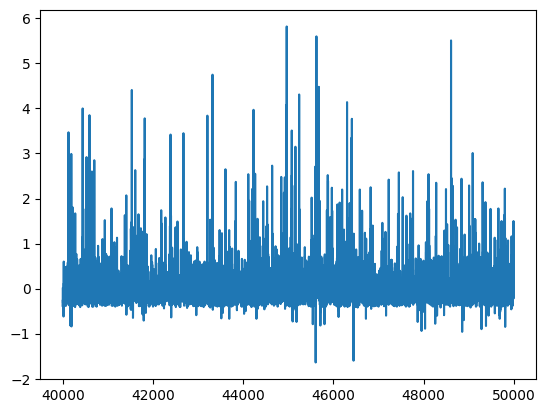

In [39]:
rewards_df['reward'][-10000:].plot()

<Axes: >

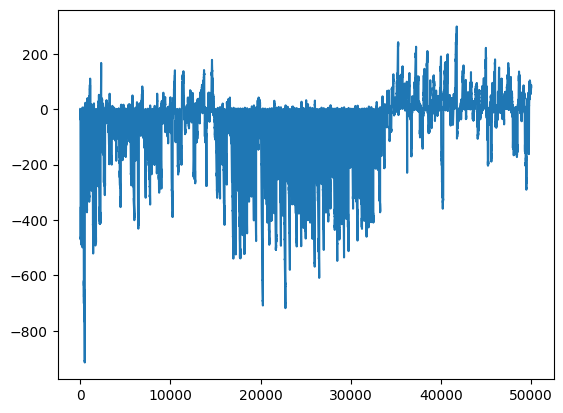

In [40]:
agent_states['equity'].plot()

<Axes: >

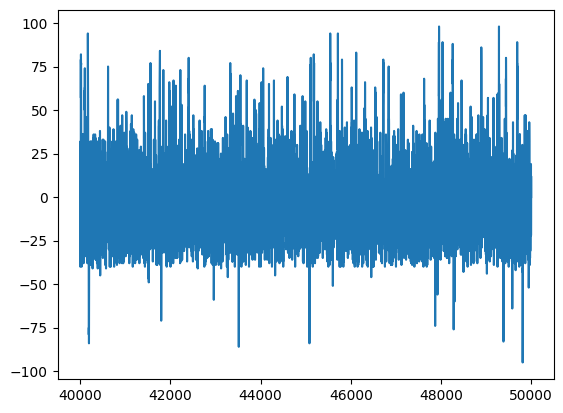

In [41]:
agent_states['assets'][-10000:].plot()

In [42]:
rewards_df.head()

,reward,executed_asks,executed_bids,current_ask_price,current_bid_price
0,0.00,0,0,0.0,0.0
1,0.00,0,0,200.9,200.2
2,-0.40,40,0,200.2,199.4
3,-0.64,24,0,201.0,200.5
4,-0.64,0,0,201.3,200.1


In [43]:
rewards_df.shape

(50000, 5)

In [44]:
0.4*8/5

0.64

In [45]:
0.64 - 

SyntaxError: invalid syntax (1611663957.py, line 1)

In [ ]:
for i in range(50):
    executed_asks = rewards_df['executed_asks'][rewards_df.shape[0] - 500 + i]
    executed_bids = rewards_df['executed_bids'][rewards_df.shape[0] - 500 + i]
    
    current_ask_price = rewards_df['current_ask_price'][rewards_df.shape[0] - 500 + i]
    current_bid_price = rewards_df['current_bid_price'][rewards_df.shape[0] - 500 + i]
    
    assets = agent_states['assets'][rewards_df.shape[0] - 500 + i - 1]
    
    reward = min(executed_asks, executed_bids) * (current_ask_price - current_bid_price) / 5
    
    print(reward)
    print(- abs(assets - (executed_asks - executed_bids)) / (100))
    
    reward = reward - abs(assets - (executed_asks - executed_bids)) / (100)
    
    print(rewards_df.shape[0] - 500 + i, round(reward, 2), round(executed_asks, 2), round(executed_bids, 2), round(current_ask_price, 2), round(current_bid_price, 2), assets)

In [ ]:
reward = min(executed_asks, executed_bids) * (current_ask_price - current_bid_price) / 5
reward = reward - abs(self.RL_agent.last_assets - (executed_asks - executed_bids)) / (self.RL_agent.limit_inventory)

In [ ]:
agent_states['cash'][-500:].plot()

In [ ]:
agent_states['assets'][-2000:].plot()

In [ ]:
results_ppo_1['train/loss'].plot()

In [ ]:
results_ppo_1['train/entropy_loss'].plot()

In [ ]:
results_ppo_1['train/approx_kl'].plot()

In [ ]:
results_ppo_1['train/policy_gradient_loss'].plot()

In [ ]:
results_ppo_1['train/value_loss'].plot()

In [ ]:
np.mean(rewards_container[27001:])

In [ ]:
rewards_container[27301:]

In [ ]:
max(results_ppo_1['time/total_timesteps'])

In [ ]:
results_ppo_1['time/total_timesteps'].plot()

In [ ]:
results_ppo_1.head()

In [ ]:
model.policy